In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh, Dropout
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from models import U_Net

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 128
input_shape = (batch_size, 1, 28,28)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

train_dataset.data = train_dataset.data[train_dataset.targets == 6]
train_dataset.targets = train_dataset.targets[train_dataset.targets == 6]

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
class v_model(Module):
    def __init__(self, input_dim, hidden_num):
        super().__init__()
        p_drop = 0.1
        self.NN = Sequential(Linear(input_dim + 1, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, input_dim, bias=True)
                            )
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.NN(inputs)

        return x

In [5]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)
        self.loss_curve = []

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0])).to(device)
        t = t[:,None]
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target


    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            pred = self.v_model(z, t)
            z = z.detach().clone() + pred * dt

            trajectory.append(z.detach().clone())

        return trajectory

In [6]:
def train_rectified_flow(rectified_flow, optimizer, train_dataloader, batchsize, epochs):
    loss_curve = rectified_flow.loss_curve
    for epoch in range(epochs):
        print("epoch: " , epoch)
        for batch in train_dataloader:
            if batch[1].shape[0] != batchsize:
                continue
            batch_target = batch[0].reshape(batch_size, 28*28).to(device)
            
            batch_init = torch.normal(torch.tensor(np.ones((batchsize, 28*28)) * 0.5), 1.0).float()
            batch_init = batch_init + torch.abs(torch.min(batch_init))
            batch_init = (255 * batch_init / torch.abs(torch.max(batch_init))).to(device)

            z_t, t, target = rectified_flow.get_train_tuple(batch_init, batch_target)

            pred = rectified_flow.v_model(z_t, t)
            loss = (target- pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
            loss = loss.mean()
            loss.backward()

            optimizer.step()
            loss_curve.append(loss.item())

    rectified_flow.loss_curve = loss_curve
    return rectified_flow, loss_curve

In [7]:
v_mod = v_model(input_dim=28*28, hidden_num=1200)
rectified_flow_1 = RectifiedFlow(v_mod)

In [8]:
#rectified_flow_1 = torch.load("./models/MNIST_test6.pth")

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19


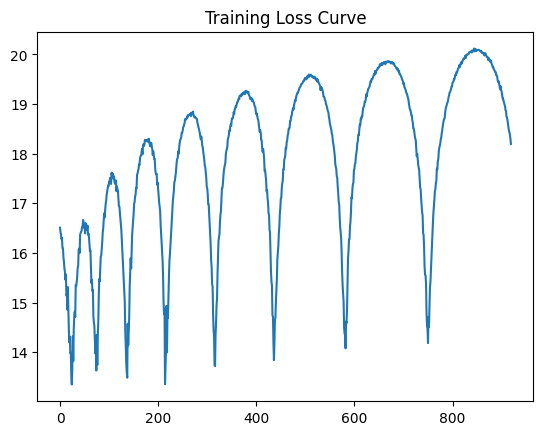

In [9]:
optimizer = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve_1 = train_rectified_flow(rectified_flow_1, optimizer, train_dataloader, batch_size, epochs=20)
torch.save(rectified_flow_1, "./models/MNIST_test6.pth")
rectified_flow_1_load = torch.load("./models/MNIST_test6.pth")
plt.plot(np.log(loss_curve_1))
plt.title("Training Loss Curve")
plt.show()

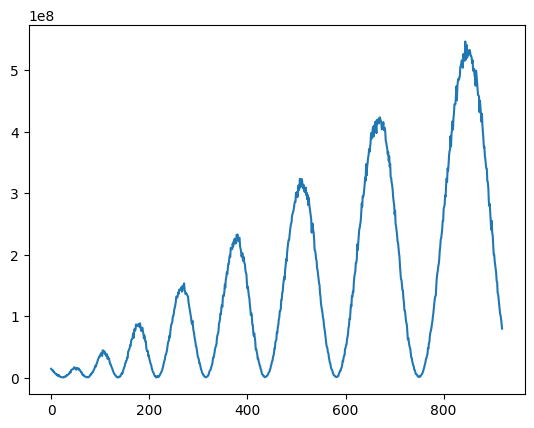

In [12]:
plt.plot(rectified_flow_1.loss_curve)

In [ ]:
#rectified_flow_1 = torch.load("./models/MNIST_test5.pth")

In [55]:
batch_init = torch.normal(torch.tensor(np.ones((batch_size,1, 32 , 32)) * 0.5), 1.0).float()
batch_init = batch_init + torch.abs(torch.min(batch_init))
batch_init = (255 * batch_init / torch.abs(torch.max(batch_init))).to(device)

tensor([[ 81.3162,  98.5120, 103.2983,  ..., 143.4829,  99.7915, 140.2042],
        [114.0075,  95.8388, 116.3059,  ...,  78.3090, 111.6878,  78.6683],
        [132.6411, 105.9025, 109.1494,  ..., 143.3653, 129.3955, 162.9817],
        ...,
        [131.3269, 125.8424, 139.1145,  ..., 106.6346,  98.8517, 112.6552],
        [157.8761, 113.1945, 118.0715,  ..., 108.5105, 124.3878, 141.5122],
        [112.3824, 139.4673, 146.0171,  ..., 118.9504, 151.4512, 122.8407]],
       device='cuda:0')
tensor([[-66.9749, -49.7791, -44.9928,  ...,  -4.8082, -48.4995,  -8.0869],
        [-34.2836, -52.4523, -23.6357,  ..., -63.7820, -36.6033, -69.6228],
        [-15.6500, -42.3886, -39.1417,  ...,  -4.9258,  30.7129,  14.6906],
        ...,
        [-16.9642, -22.4487,  -9.1766,  ..., -19.7246, -49.4394, -35.6359],
        [  9.5850, -35.0965, -30.2196,  ..., -39.7806,   6.4978,  -6.7789],
        [-35.9087,  -8.8237,  -2.2740,  ..., -29.3407,   3.1601, -25.4504]],
       device='cuda:0')


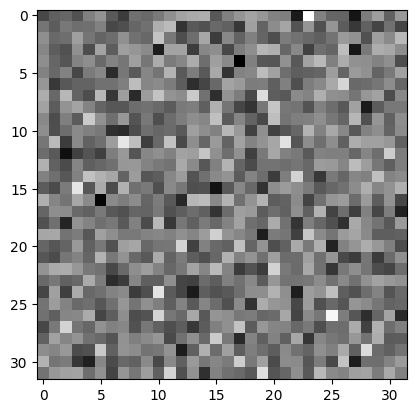

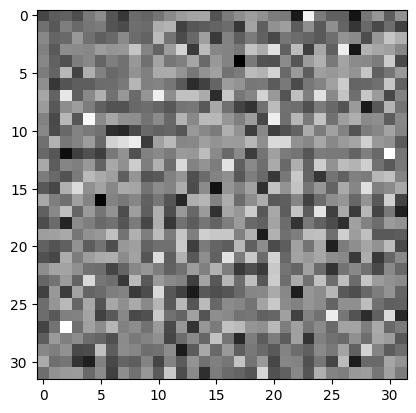

In [57]:
curr_img = 0
img = rectified_flow_1_load.sample_ode(batch_init[:1], 100)
print(batch_init[0, 0])
print(img[-1][curr_img].reshape(32,32))
plt.imshow(batch_init[0, 0].detach().cpu().numpy(), cmap="gray")
plt.show()
plt.imshow(img[-1][curr_img].reshape(32,32).detach().cpu().numpy(), cmap="gray")
plt.show()

In [13]:
v_mod_2 = v_model(input_dim, 784)
rectified_flow_2 = RectifiedFlow(v_mod_2)
flow_1 = rectified_flow_1.sample_ode(train_dataset_init, 100)
pairs_2 = torch.stack([train_dataset_init, flow_1[:][-1]], axis=1)

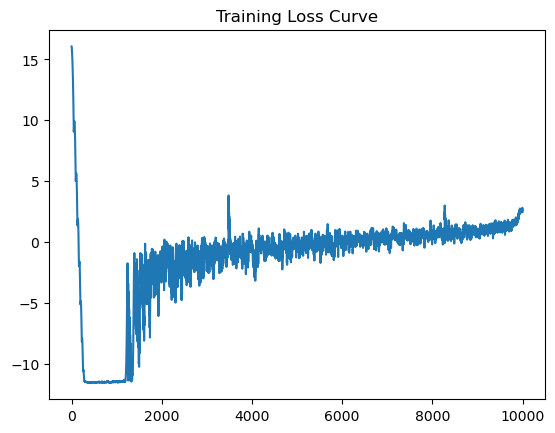

In [14]:
optimizer = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer, pairs_2, batch_size, inner_iters)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

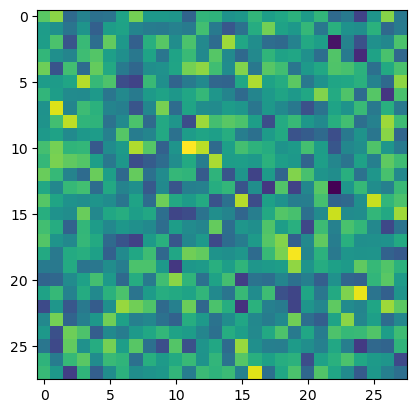

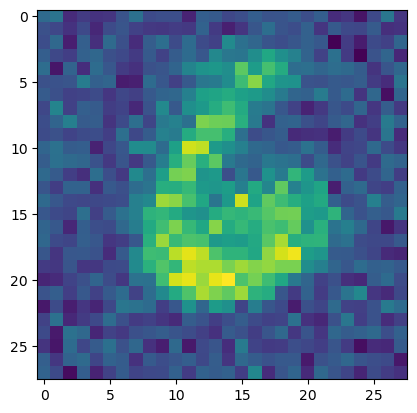

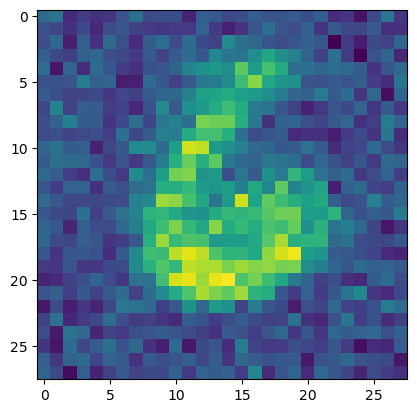

In [45]:
curr_img = 0
img = rectified_flow_2.sample_ode(pairs_1[:100][0], 1)
plt.imshow(pairs_2[curr_img][0].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_2[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()

In [16]:
del v_mod
torch.cuda.empty_cache()
v_mod_3 = v_model(input_dim, 784)
rectified_flow_3 = RectifiedFlow(v_mod_3)
flow_2 = rectified_flow_2.sample_ode(train_dataset_init, 100)
pairs_3 = torch.stack([train_dataset_init, flow_2[:][-1]], axis=1)

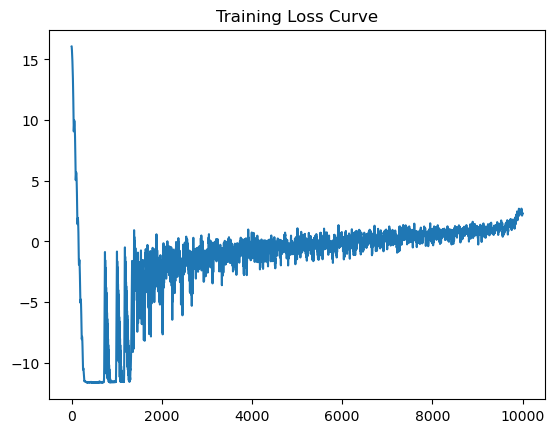

In [17]:
optimizer = torch.optim.Adam(rectified_flow_3.v_model.parameters(), lr=5e-3)

rectified_flow_3, loss_curve_3 = train_rectified_flow(rectified_flow_3, optimizer, pairs_3, batch_size, inner_iters)
plt.plot(np.log(loss_curve_3))
plt.title("Training Loss Curve")
plt.show()

torch.Size([100, 784])


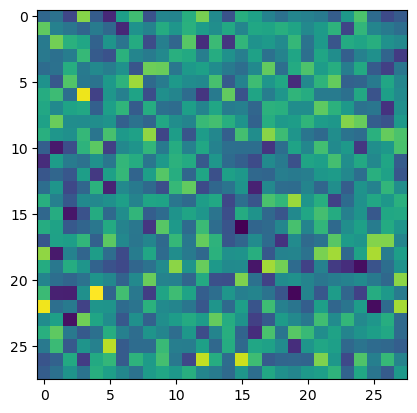

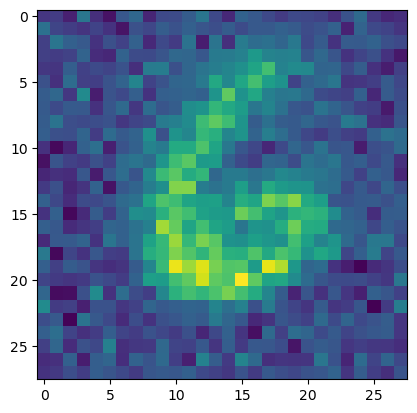

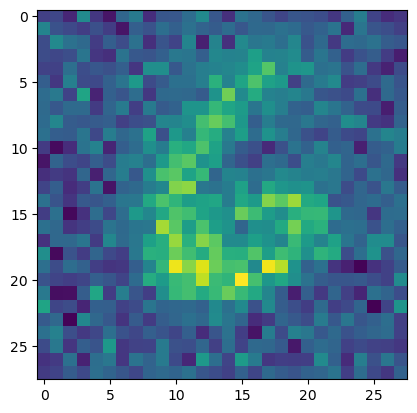

In [67]:
curr_img = 30
img = rectified_flow_3.sample_ode(train_dataset_init[:100], 100)
print(img[-1].shape)
plt.imshow(train_dataset_init[curr_img].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_3[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[70][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()